In [1]:
from src.Funciones import *

In [2]:
class sistema:
    def __init__(self, lor, name="", th=0.0):
        '''
        Inicializa el 'sistema' formado por la lista de Redes descrita en 'lol' dandole el nombre 'name'.
        lol  -> Lista de redes que conforman el sistema
        name -> Nombre del sistema
        '''
        self.redes = lor #Lista de Redes del Sistema
        self.name = 'Sistema ['+','.join([l.name for l in lor])+']' #Nombre del Sistema
        self.theta = th  #Ángulo entre capas de un sistema binario
        self.resultados = []#Lista de Puntos de red comunes para todas las capas
        self.loMat = []  #Lista de Matrices de transformación sugeridas
        self.MaxNumM = 10 #Número maximo de Matrices sugeridas
        self.SuperRed = None  #Super-Red del Sistema
    
    def goesHere(self, M, i):
        '''
        Determina si una Matriz de transformacion M entra o no en la posición i de la lista loMat
        M -> Matriz a examinar
        i -> posición que examinamos
        '''
        if i>=len(self.loMat):#Si el indice sobrepasa los validos
            if len(self.loMat)<self.MaxNumM:#Verifica si aaun hay espacio en loMat
                return True,i
            print("\t--Matriz descartada")
            return False, -1 #La matriz M es peor que las de loMat
        dM = det(M)
        d = det(self.loMat[i])
        if dM < d:# M es mejor opción que la que está actualmente en i
            print("\t--Nueva mejor en {}".format(i))
            return True, i
        if dM == d:
            a,b = transforma2v(self.redes[0].a,self.redes[0].b,M)
            c,d = transforma2v(self.redes[0].a,self.redes[0].b,self.loMat[i])
            if esRotacion(a,b,c,d):#Si el resultado es rotación del que ya tenemos lo descarta
                print("\t--Matriz rotada existente")
                return False, -1
            b, i = self.goesHere(M,i+1)#Verifica en la siguiente posición
            return b, i
        if dM%d==0:#Si el resultado es un multiplo del que tenemos lo descarta
            print("\t--Matriz crecida {} veces".format(dM/d))
            return False, -1
        b, i = self.goesHere(M,i+1)#Verifica en la siguiente posición
        return b, i
    
    def adjust(self, M):
        '''
        Verifica si una matriz de trasformación M entra a la lista loMat y la coloca manteniendo el orden
        M -> Matriz a examinar
        '''
        if det(M)==0:
            print("---Matriz invalida--")
            return 0
        b, i = self.goesHere(M,0)
        if b:
            print("--Matriz agregada--(",M,")")
            if len(self.loMat)<self.MaxNumM:
                self.loMat.append(M)
            else:
                self.loMat.insert(i,M)
                del self.loMat[-1]
        print("---Matriz rechazada--")
        return 1
    
    def calculateTransformationMatrices(self):
        '''
        Genera una lista de matrices de trasformación optimas de menor tamaño a partir
        de la lista 'resultados' del sistema.
        '''
        if self.resultados == []:
            errmsg = "No hay puntos de red en común para las capas."
            errmsg +="\nEjecute la función calculateSharedLP"
            errmsg +="\n*En caso de ya haberlo hecho aumente el rango de búsqueda (rangeOfSearch) o el error mínimo aceptado (epsilon)"
            print(errmsg)
            return -1
        print("Generando Matrices a partir de {} puntos".format(len(self.resultados)))
        self.loMat = []
        print("Áng1={},Áng2={}".format(self.redes[0].inAngle,self.redes[1].inAngle))
        if round(self.redes[0].inAngle)==120:
            if round(self.redes[1].inAngle)==120:
                print("Sistema binario exagonal")
                for r in self.resultados:
                    [m,n]=r[0]
                    M = vTm((m,n),(-n,m-n))
                    self.adjust(M)
                    return 0
        for i in range(len(self.resultados)):
            for j in range(i+1,len(self.resultados)):
                print("Arreglo ({},{})".format(i,j))
                [a1,a2] = self.resultados[i][0]
                [b1,b2] = self.resultados[j][0]
                M = vTm((a1,a2),(b1,b2))
                if det(M)<0:
                    M = vTm((b1,b2),(a1,a2))
                a,b = transforma2v(s.redes[0].a,s.redes[0].b,M)
                if cAng(a,b)>10:
                    print("Analizando:",M)
                    self.adjust(M)
                else:
                    print(" - -Red generada con ángulo menor a 10°")
        return 1
        
    def createSuperLattice(self,M):
        '''
        Crea la red que representa al sistema.
        Los vectores primitivos de esta red se obtienen de transformar los vectores primitivos de la red de la
        primer capa con la matriz de transformación M dada.
        M -> Matríz de trasformación para los vectores primitivos
        '''
        sa, sb = transforma2v(self.redes[0].a,self.redes[0].b,M)
        self.SuperRed = superMesh(sa,sb,self.redes)
        return 1
    
    def calculateSharedLP(self, rangeOfSearch=15, epsilon=0.1):
        '''
        Busca las variables que desciben las transformaciones que debe tener cada Red del sistema para coincidir
        con una Super-Red común a todas ellas.
        rangeOfSearch -> Rango de busqueda de los posibles valores de transformaciòn de la red 1 (15 por Default)
        epsilon       -> Error máximo permitido para las transformaciones (0.1 por Default)
        '''
        if len(self.redes)==2:
            lor,s = calculaPares(self.redes[0], self.redes[1], th=self.theta, maxIt=rangeOfSearch, eps=epsilon)
            print(len(lor))
            self.resultados = lor
        
    def analyze(self, rangeOfAngleSearch=(0.0,180.0), rangeOfSearch=15, precision=2, maxErr=0.05):
        '''
        Analiza el sistema buscando los ángulos de rotaciòn para red2 en los que sin modificar las redes el error es mínimo.
        rangeOfAngleSearch -> Rango de búsqueda para el ángulo señalado por el par (ángulo inicial, ángulo final)
        rangeOfSearch      -> Rango de busqueda de los posibles valores de transformaciòn de la red 1
        precision          -> Precición de la busqueda dada por la cantidad de dìgitos despues del punto en que se busca
                              (1=decimos de grado,2=centecimos de grado,...)
        maxErr             -> Error màximo tolerable para ser aceptado
        '''
        if len(self.redes)==2:
            return analiza(self.redes[0],self.redes[1],roAng=rangeOfAngleSearch,erMax=maxErr,mor=rangeOfSearch,accuracy=precision)
    
    def show(self):
        print(self.name,"\nCelda unitaria:")
        self.SuperRed.showme()
        print("Espacio Reciproco:")
        self.SuperRed.printReciprocalSpace()

In [3]:
atomos=[Atomo((0.333333343,0.666666687),posZ=0.500000000,color='Red',sig='Cd'),
        Atomo((0.666666627,0.333333313),posZ=0.250000000,color='Red',sig='Cd'),
        Atomo((0.333333343,0.666666687),posZ=0.1899999975,color='gold',sig='S'),
        Atomo((0.666666627,0.333333313),posZ=0.4399999975,color='gold',sig='S')]
CdS=Red((4.2100000381,0.0000000000),(-2.1050000191,3.6459669830),atms=atomos, detachment=13.6800003052 ,name='CdS')

atmsG=[Atomo((0.000000000,0.000000000)),Atomo((0.333333343,0.666666687))]
grafeno=Red((2.4410462379,0.0000000000),(-1.2205231190,2.1140080539),atms=atmsG,name='Grafeno')

In [4]:
r1=grafeno.mRot(29.45)
r2=blackPhospho()

In [23]:
s=sistema([r1,r2])

In [24]:
print(s.name)

Sistema [Grafeno(rot 29.45°),Black-Phosphorene]


In [25]:
#s.analyze(rangeOfAngleSearch=(0.0,90.0))

In [26]:
s.calculateSharedLP(rangeOfSearch=20,epsilon=0.2)

6


In [27]:
s.resultados

[[[0, -11], [7, -3], 0.9992346811652929, 0.020644673751821507],
 [[0, 11], [-7, 3], 0.9992346811652929, 0.020644673751821507],
 [[9, -5], [9, 1], 0.9965068189726585, 0.12211002915443238],
 [[9, 6], [2, 4], 1.0001130795262987, 0.10151806154212534],
 [[9, -16], [16, -2], 0.9974050690994067, 0.14271722646394444],
 [[9, 17], [-5, 7], 1.001658831390439, 0.08095294637679315]]

In [28]:
s.calculateTransformationMatrices()

Generando Matrices a partir de 6 puntos
Áng1=120.00000000000001,Áng2=90.0
Arreglo (0,1)
Analizando: [[0, 0], [-11, 11]]
---Matriz invalida--
Arreglo (0,2)
Analizando: [[0, 9], [-11, -5]]
--Matriz agregada--( [[0, 9], [-11, -5]] )
---Matriz rechazada--
Arreglo (0,3)
Analizando: [[0, 9], [-11, 6]]
--Matriz agregada--( [[0, 9], [-11, 6]] )
---Matriz rechazada--
Arreglo (0,4)
Analizando: [[0, 9], [-11, -16]]
--Matriz agregada--( [[0, 9], [-11, -16]] )
---Matriz rechazada--
Arreglo (0,5)
Analizando: [[0, 9], [-11, 17]]
--Matriz agregada--( [[0, 9], [-11, 17]] )
---Matriz rechazada--
Arreglo (1,2)
Analizando: [[9, 0], [-5, 11]]
--Matriz agregada--( [[9, 0], [-5, 11]] )
---Matriz rechazada--
Arreglo (1,3)
Analizando: [[9, 0], [6, 11]]
--Matriz agregada--( [[9, 0], [6, 11]] )
---Matriz rechazada--
Arreglo (1,4)
Analizando: [[9, 0], [-16, 11]]
--Matriz agregada--( [[9, 0], [-16, 11]] )
---Matriz rechazada--
Arreglo (1,5)
Analizando: [[9, 0], [17, 11]]
--Matriz agregada--( [[9, 0], [17, 11]] )
-

1

In [29]:
s.loMat

[[[0, 9], [-11, -5]],
 [[0, 9], [-11, 6]],
 [[0, 9], [-11, -16]],
 [[0, 9], [-11, 17]],
 [[9, 0], [-5, 11]],
 [[9, 0], [6, 11]],
 [[9, 0], [-16, 11]],
 [[9, 0], [17, 11]],
 [[9, 9], [-5, 6]],
 [[9, 9], [-16, -5]]]

In [30]:
for m in s.loMat:
    a,b = transforma2v(s.redes[0].a,s.redes[0].b,m)
    t=cAng(a,b)
    print(m,":Det={},Theta={}\tu={}v={}".format(det(m),t,long(a),long(b)))

[[0, 9], [-11, -5]] :Det=99,Theta=39.366911822161285	u=26.851508617805333v=29.996078361870197
[[0, 9], [-11, 6]] :Det=99,Theta=100.89326415545375	u=26.851508617805333v=19.375203852912758
[[0, 9], [-11, -16]] :Det=99,Theta=20.817043996220164	u=26.851508617805333v=53.53632355648954
[[0, 9], [-11, 17]] :Det=99,Theta=148.05539077821396	u=26.851508617805333v=35.95885651263874
[[9, 0], [-5, 11]] :Det=99,Theta=140.63308817783872	u=29.996078361870197v=26.851508617805333
[[9, 0], [6, 11]] :Det=99,Theta=79.10673584454626	u=19.375203852912758v=26.851508617805333
[[9, 0], [-16, 11]] :Det=99,Theta=159.18295600377982	u=53.53632355648954v=26.851508617805333
[[9, 0], [17, 11]] :Det=99,Theta=31.944609221786035	u=35.95885651263874v=26.851508617805333
[[9, 9], [-5, 6]] :Det=99,Theta=61.52664636550447	u=29.996078361870197v=19.375203852912758
[[9, 9], [-16, -5]] :Det=99,Theta=18.54935047375373	u=53.53632355648954v=29.996078361870197


In [31]:
s.createSuperLattice(s.loMat[4])

1

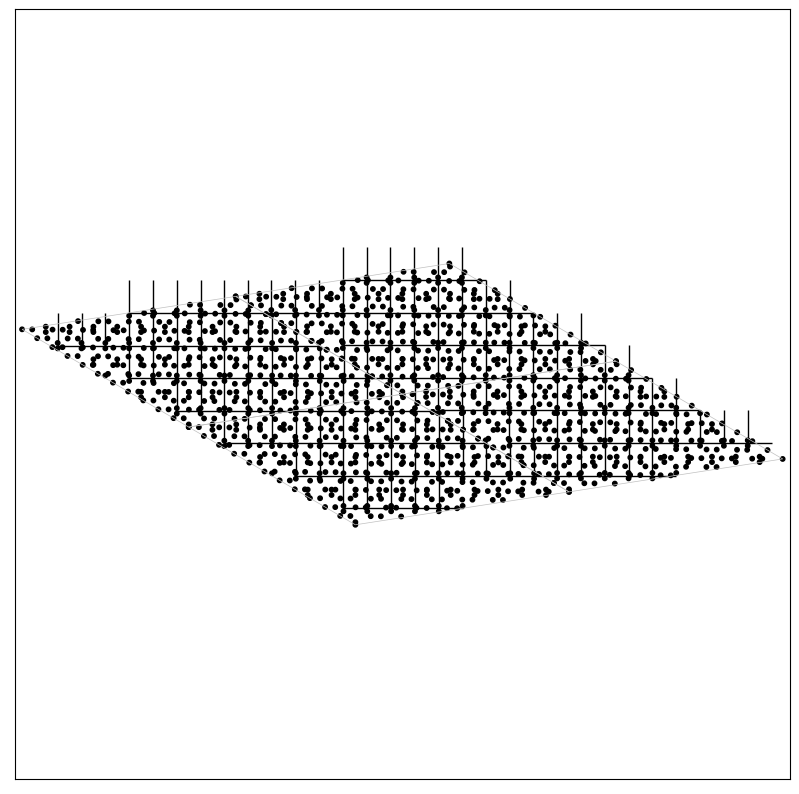

1

In [32]:
s.SuperRed.showXY(2,2)

Sistema [Grafeno(rot 29.45°),Black-Phosphorene] 
Celda unitaria:


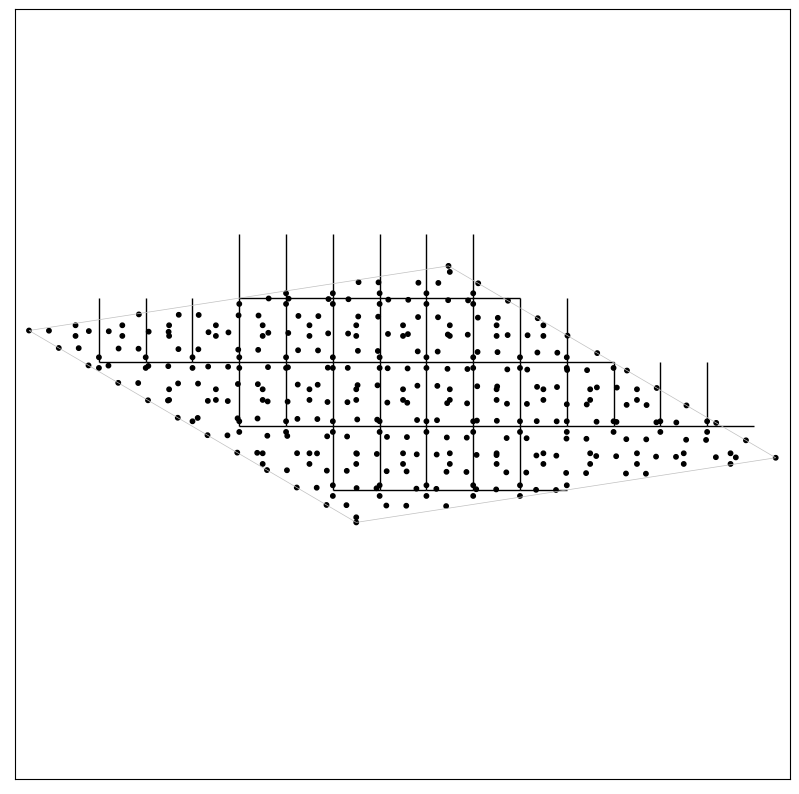

Espacio Reciproco:
Calculando...
...Pintando capa 1 (Grafeno(rot 29.45°))
...Pintando capa 2 (Black-Phosphorene)
...Terminado


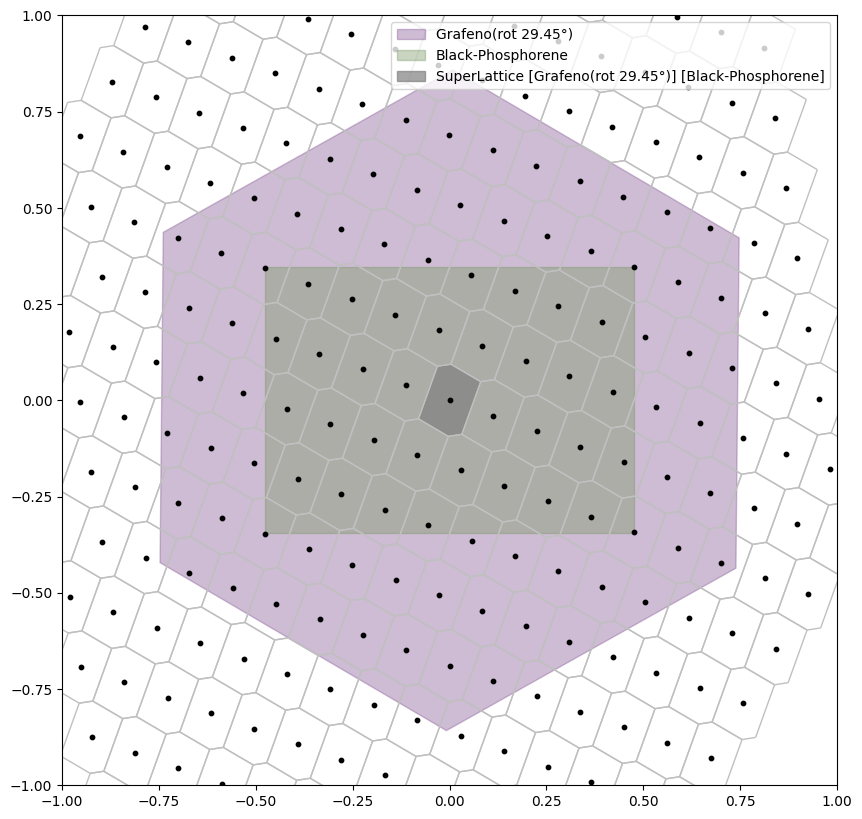

In [33]:
s.show()

Calculando...
...Pintando capa 1 (Black-Phosphorene(rot 8.76°))
...Pintando capa 2 (Grafeno(rot 38.21°))
...Terminado


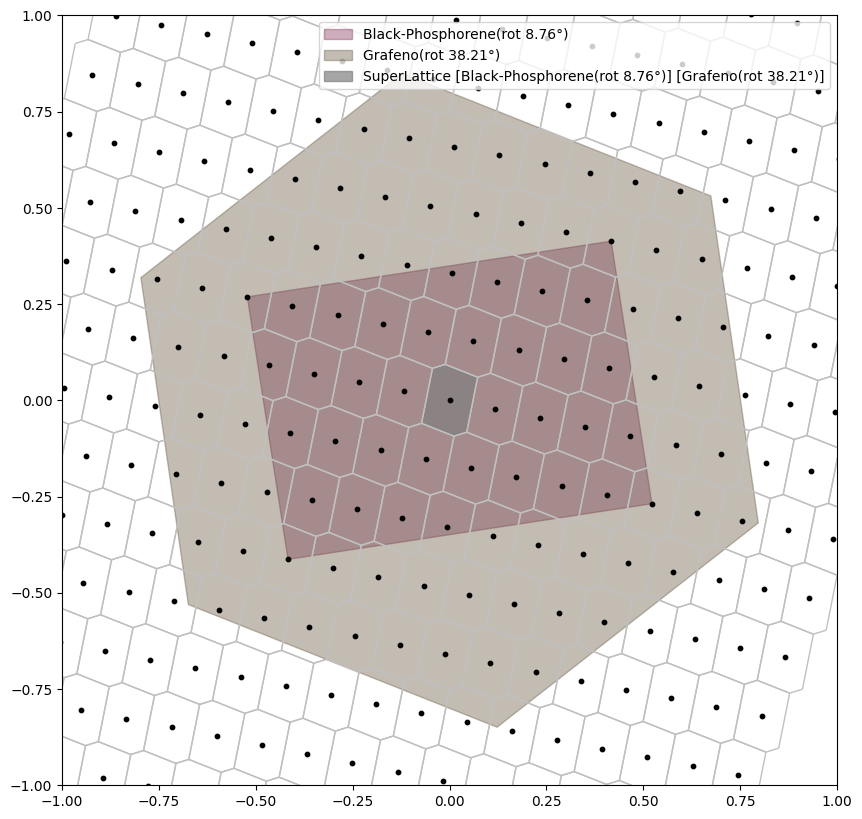

1

In [20]:
s.SuperRed.printReciprocalSpace()

In [74]:
tam=(2.44)*(1-0.05)
tam2=2.44
vct=(tam,0)
aux1,aux2=transfVs(vct,rota(vct,120),(4,8,-8,12))
A,B=transforma2v(aux1,aux2,inv2x2([[-8,12],[-11,4]]))
print(m2V(A,B,(6,2)))
print(A,B)

(2.318000000000003, 12.044681315833975)
(1.2517200000000006, 2.007446885972329) (-2.5961600000000002, 0.0)


In [75]:
g1=grafeno()
g2=grafeno()

(2.318000000000003, 12.044681315833975)
(1.2517200000000006, 2.007446885972329) (-2.5961600000000002, 0.0)
Tam vectores:2.3657231364637754,2.5961600000000002
Angulo interno: 121.94534081700915
% de distorción:-3.0441337514846123,6.400000000000006 3.3558662485153934
Tam medio=2.480941568231888
Coorelación:1.070294032886923


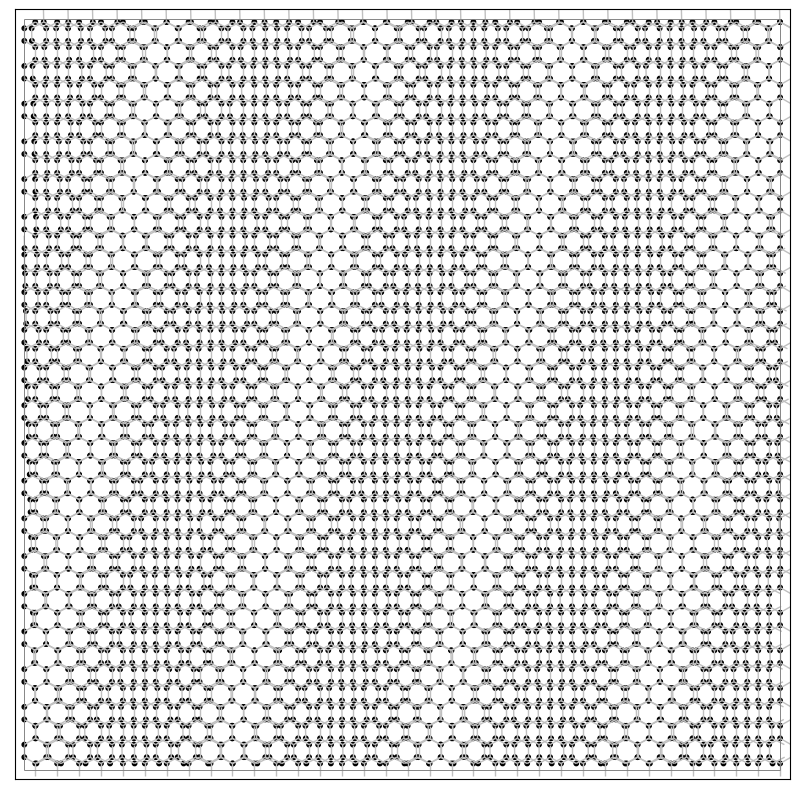

In [83]:
tam=(2.44)*(1-0.05)
tam2=2.44
vct=(tam,0)
aux1,aux2=transfVs(vct,rota(vct,120),(4,8,-8,12))
A,B=transforma2v(aux1,aux2,inv2x2([[-8,12],[-11,4]]))
print(m2V(A,B,(6,2)))
print(A,B)
#print(m2V(vec1,rota(vec1,120),(4,6)))
print("Tam vectores:{},{}".format(dist((0,0),A),dist(B,(0,0))))
print("Angulo interno:",cAng(A,B))
d1,d2=((dist((0,0),A)/tam2)-1)*100,((dist(B,(0,0))/tam2)-1)*100
print("% de distorción:{},{}".format(d1,d2),d1+d2)
tm = (dist((0,0),A)+dist(B,(0,0)))/2
print("Tam medio={}\nCoorelación:{}".format(tm,tm/tam))
#(vec1,rota(vec1,120))
g1.setNewVectors(vct,rota(vct,120))
g2.setNewVectors(A,B)
superMesh((80,0),(0,80),[g1,g2]).showme()

In [89]:
[g1.a,g1.b,g2.a,g2.b],aux1,aux2

([(2.318, 0),
  (-1.1589999999999996, 2.007446885972329),
  (1.2517200000000006, 2.007446885972329),
  (-2.5961600000000002, 0.0)],
 (18.543999999999997, -16.059575087778633),
 (4.636000000000006, 24.08936263166795))

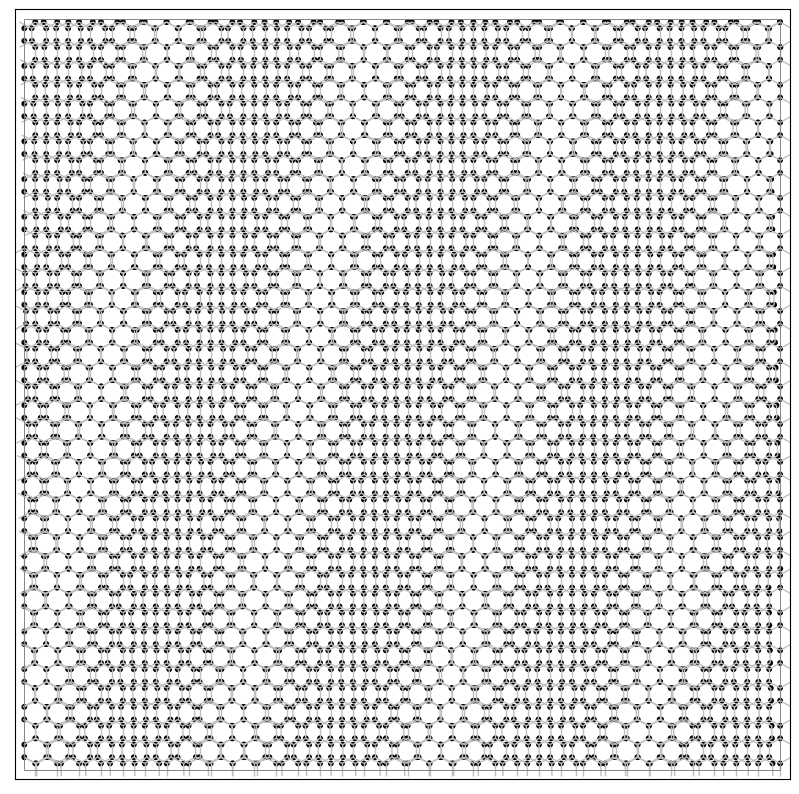

In [85]:
graf1=grafeno()
graf2=grafeno()
graf1.setNewVectors((2.318, 0),(-1.1589999999999996, 2.007446885972329))
graf2.setNewVectors((-2.5961600000000002, 0.0),(1.2517200000000006, 2.007446885972329))
superMesh((80,0),(0,80),[graf1,graf2]).showme()

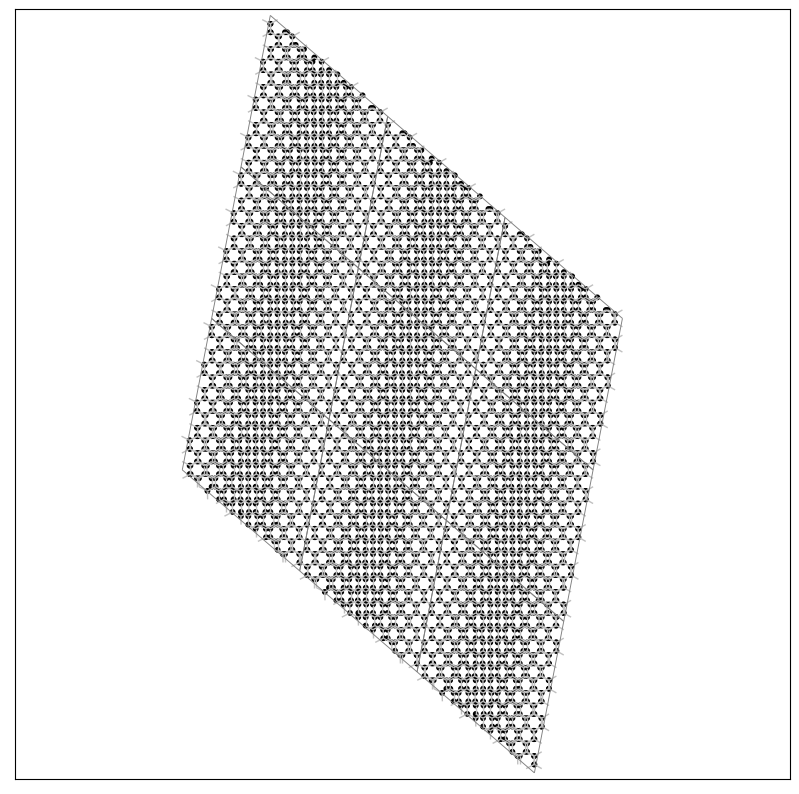

In [88]:
gg=superMesh(aux1,aux2,[graf1,graf2]).showXY(3,3)

['#1688B4', '#2006FD', '#5AAF46', '#AB6ADE', '#F163DF', '#7659BD', '#5A13A6', '#03108E', '#8E9F36', '#220BC9']


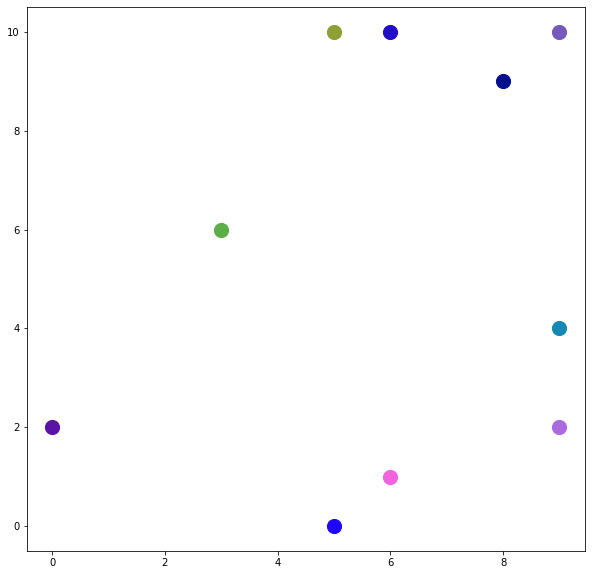

In [10]:
import random
colors=10
color=['#'+''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for j in range(colors)]
print(color)
for j in range(colors):
	plt.scatter(random.randint(0,10),random.randint(0,10),c=color[j],s=200)
plt.show()

In [8]:
import random

print(random.randint(3, 9))

9
